# 지금까지 만든 자료들을 가지고 시각화를 한다
## 데이터 출처 : 대중교통 빅데이터 시스템 (https://www.stcis.go.kr/wps/main.do)

In [1]:
import mysql.connector

In [2]:
conn = mysql.connector.connect(
    host = "database-1.c3ieyo8m4v9o.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "eda_team",
    password = "123456",
    database = "eda_project"
)

In [3]:
cursor = conn.cursor(dictionary=True, buffered=True)

In [4]:
cursor.execute("select * from method_traffic")

In [5]:
data = cursor.fetchall()

In [6]:
import pandas as pd

raw_data = pd.DataFrame(data)

/tmp/ipykernel_4875/1595393203.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 시간별 데이터를 합쳐서 오전, 오후 데이터를 만든다

In [7]:
raw_data["오전발생량"] = raw_data["4시발생량"]+raw_data["5시발생량"]+raw_data["6시발생량"]+raw_data["7시발생량"]+raw_data["8시발생량"]+raw_data["9시발생량"]+raw_data["10시발생량"]+raw_data["11시발생량"]+raw_data["24시발생량"]+raw_data["1시발생량"]+raw_data["2시발생량"]+raw_data["3시발생량"]
raw_data["오후발생량"] = raw_data["12시발생량"]+raw_data["13시발생량"]+raw_data["14시발생량"]+raw_data["15시발생량"]+raw_data["16시발생량"]+raw_data["17시발생량"]+raw_data["18시발생량"]+raw_data["19시발생량"]+raw_data["20시발생량"]+raw_data["21시발생량"]+raw_data["22시발생량"]+raw_data["23시발생량"]

In [8]:
raw_data["오전도착량"] = raw_data["4시도착량"]+raw_data["5시도착량"]+raw_data["6시도착량"]+raw_data["7시도착량"]+raw_data["8시도착량"]+raw_data["9시도착량"]+raw_data["10시도착량"]+raw_data["11시도착량"]+raw_data["24시도착량"]+raw_data["1시도착량"]+raw_data["2시도착량"]+raw_data["3시도착량"]
raw_data["오후도착량"] = raw_data["12시도착량"]+raw_data["13시도착량"]+raw_data["14시도착량"]+raw_data["15시도착량"]+raw_data["16시도착량"]+raw_data["17시도착량"]+raw_data["18시도착량"]+raw_data["19시도착량"]+raw_data["20시도착량"]+raw_data["21시도착량"]+raw_data["22시도착량"]+raw_data["23시도착량"]

## 도착량(내림)과 발생량(탑승)의 차이로 유입량(외부지역에서 오는양)을 계산한다

In [9]:
raw_data["오전유입량"] = raw_data["오전도착량"] - raw_data["오전발생량"]
raw_data["오후유입량"] = raw_data["오후도착량"] - raw_data["오후발생량"]

In [10]:
sido_inout_pivot = pd.pivot_table(raw_data, index="시도",values=["오전유입량","오후유입량"],aggfunc='sum')
sido_inout_pivot /=2250
sido_inout_pivot

,오전유입량,오후유입량
시도,,
경기도,-383921.250667,314907.707111
서울특별시,197570.984889,-317690.417333
인천광역시,-87820.417333,53304.458667


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# 시도별 오전,오후에 인구 유출,유입량 (하루 평균)

<Figure size 800x800 with 0 Axes>

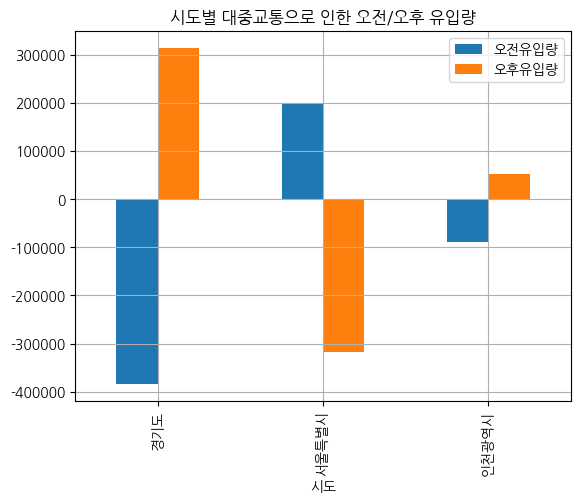

In [68]:
plt.figure(figsize=(8,8))
sido_inout_pivot.plot(kind="bar", grid=True)
plt.title("시도별 대중교통으로 인한 오전/오후 유입량")
plt.show()

### 경기도, 인천은 오전에 빠져나가서 오후에 돌아온다
### 서울은 오전에 들어오고 오후에 빠져나간다

In [13]:
gu_inout_pivot = pd.pivot_table(raw_data, index="시군구",values=["오전유입량","오후유입량"],aggfunc='sum')
gu_inout_pivot/=2250

## 오전에 가장 많이 유출되는 시군구 top10

<Figure size 1500x2000 with 0 Axes>

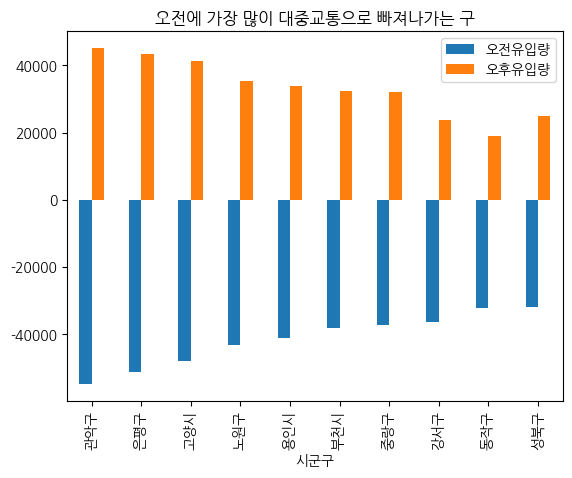

In [67]:
plt.figure(figsize=(15,20))
gu_inout_pivot.sort_values(by="오전유입량", ascending=True).head(10).plot(kind="bar")
plt.title("오전에 가장 많이 대중교통으로 빠져나가는 구")
plt.show()

## 의외로 빠져나가는 사람이 가장 많은 지역은 경기도가 아니라 관악구였다

## 오전에 가장 많이 유입되는 시군구 top 10

<Figure size 1500x2000 with 0 Axes>

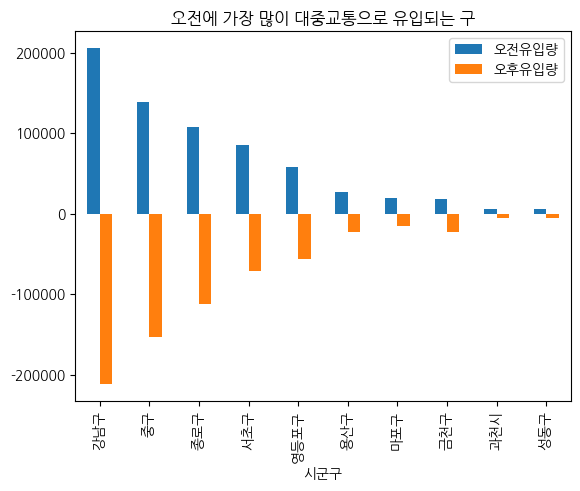

In [66]:
plt.figure(figsize=(15,20))
gu_inout_pivot.sort_values(by="오전유입량", ascending=False).head(10).plot(kind="bar")
plt.title("오전에 가장 많이 대중교통으로 유입되는 구")
plt.show()

## 강남구에 가장 사람들이 많이 몰린다

In [16]:
sido_use_pivot = pd.pivot_table(raw_data, index="시도",values="합계발생량", aggfunc='sum').sort_values(by="합계발생량", ascending=False)
sido_use_pivot /= 2250

## 하루평균 시도별 대중교통 이용수 (탑승기준)

<Figure size 800x600 with 0 Axes>

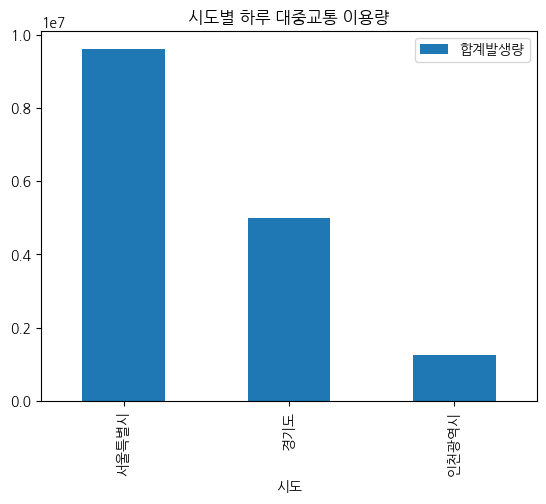

In [65]:
plt.figure(figsize=(8,6))
sido_use_pivot.plot(kind="bar")
plt.title("시도별 하루 대중교통 이용량")
plt.show()

## 서울에서 하루평균 100만번을 탑승한다
## 경기도와 인천은 인구수에 비해 대중교통 탑승량이 적다

In [18]:
use_pivot = pd.pivot_table(raw_data, index="시군구",values="합계발생량", aggfunc='sum').sort_values(by="합계발생량", ascending=False)
use_pivot /=2250

## 대중교통 이용 시군구 순위 top 10

<Figure size 800x600 with 0 Axes>

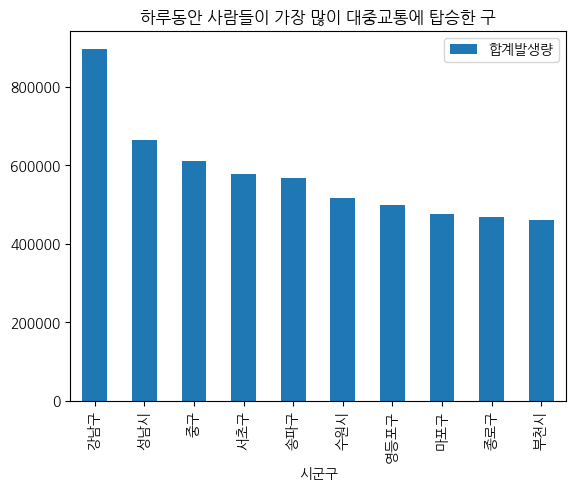

In [64]:
plt.figure(figsize=(8,6))
use_pivot.head(10).plot(kind="bar")
plt.title("하루동안 사람들이 가장 많이 대중교통에 탑승한 구")
plt.show()

## 가장 적게 탑승하는 시군구 top 10
### 강남구와 가평군은 100배정도 차이난다

<Figure size 800x600 with 0 Axes>

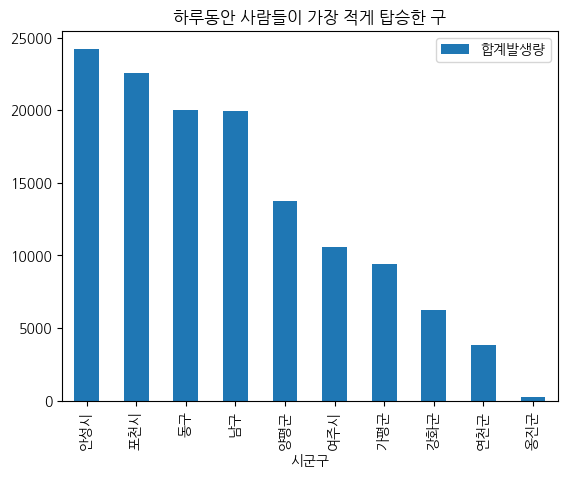

In [62]:
plt.figure(figsize=(8,6))
use_pivot.tail(10).plot(kind="bar")
plt.title("하루동안 사람들이 가장 적게 탑승한 구")
plt.show()

## 사람들이 내리는 양

In [21]:
drop_pivot = pd.pivot_table(raw_data, index="시군구",values="합계도착량", aggfunc='sum').sort_values(by="합계도착량", ascending=False)
drop_pivot /=2250

<Figure size 800x600 with 0 Axes>

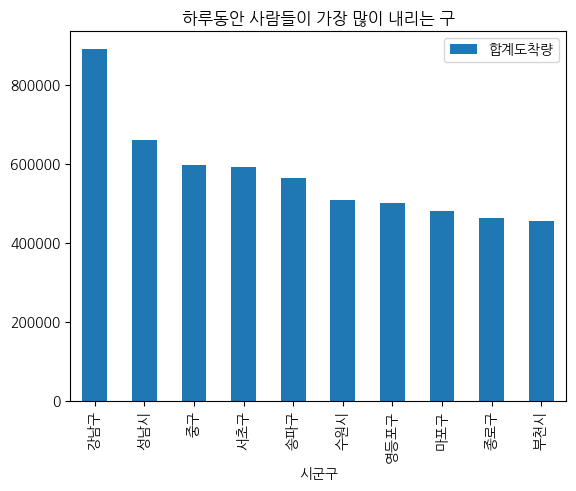

In [60]:
plt.figure(figsize=(8,6))
drop_pivot.head(10).plot(kind="bar")
plt.title("하루동안 사람들이 가장 많이 내리는 구")
plt.show()

<Figure size 800x600 with 0 Axes>

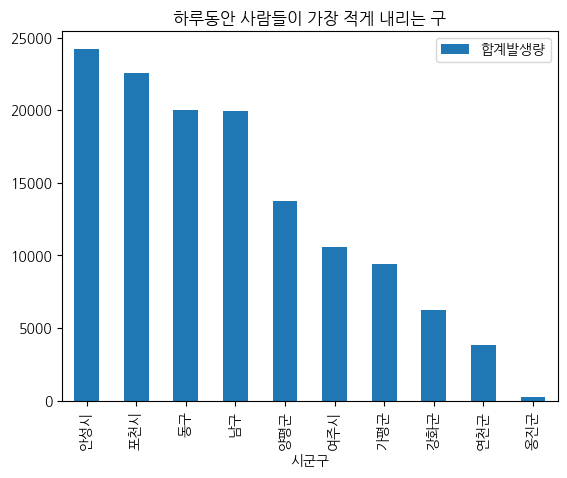

In [61]:
plt.figure(figsize=(8,6))
use_pivot.tail(10).plot(kind="bar")
plt.title("하루동안 사람들이 가장 적게 내리는 구")
plt.show()

## 타는양과 내리는 양은 순위 변동이 거의 없다 (있긴 있다)

In [24]:
cursor.execute("""select 연월, sum(합계발생량) as 합계발생량 from method_traffic where 시도="서울특별시" group by 연월""")
seoul_use_by_date = pd.DataFrame(cursor.fetchall())

In [25]:
cursor.execute("""select 연월, sum(합계발생량) as 합계발생량 from method_traffic where 시도="경기도" group by 연월""")
gyunggi_use_by_date = pd.DataFrame(cursor.fetchall())

In [26]:
cursor.execute("""select 연월, sum(합계발생량) as 합계발생량 from method_traffic where 시도="인천광역시" group by 연월""")
incheon_use_by_date = pd.DataFrame(cursor.fetchall())

## 서울,경기도,인천의 대중교통 월별 이용수

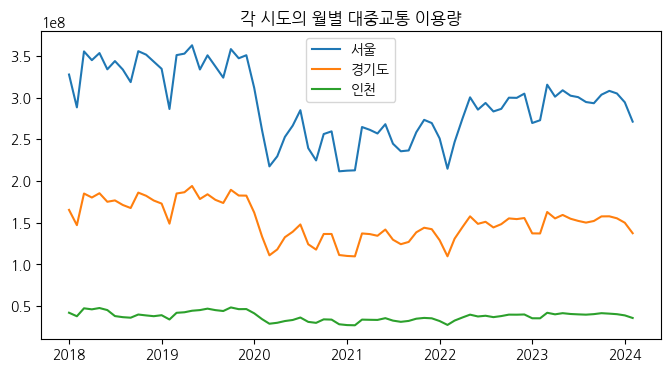

In [58]:
from datetime import datetime
plt.figure(figsize=(8,4))
plt.plot(pd.to_datetime(seoul_use_by_date["연월"],format="%Y%m"), seoul_use_by_date["합계발생량"], label="서울")
plt.plot(pd.to_datetime(gyunggi_use_by_date["연월"],format="%Y%m"), gyunggi_use_by_date["합계발생량"], label="경기도")
plt.plot(pd.to_datetime(incheon_use_by_date["연월"],format="%Y%m"), incheon_use_by_date["합계발생량"], label="인천")
plt.legend()
plt.title("각 시도의 월별 대중교통 이용량")
plt.show()


## 서울, 경기도, 인천 순으로 이용수가 많고 연말,연초에 순간적으로 탑승량이 떨어진다

## 일반인 시간별 탑승량

In [28]:
sql="""select 교통수단, sum(1시발생량),sum(2시발생량),sum(3시발생량), sum(4시발생량),sum(5시발생량),sum(5시발생량),sum(6시발생량),sum(7시발생량),sum(8시발생량),sum(9시발생량),sum(10시발생량),sum(11시발생량),sum(12시발생량),sum(13시발생량),sum(14시발생량),sum(15시발생량),sum(16시발생량),sum(17시발생량),sum(18시발생량),sum(19시발생량),sum(20시발생량),sum(21시발생량),sum(22시발생량),sum(23시발생량),sum(24시발생량) from method_traffic where 이용자유형="일반인" group by 교통수단"""
cursor.execute(sql)
transp_way = pd.DataFrame(cursor.fetchall())

In [29]:
column_name=['교통수단']
for i in range(1,25):
    column_name.append(i)

In [30]:
transp_way.columns=column_name

In [31]:
transp_way = transp_way.set_index("교통수단", drop=True)

In [32]:
transp_way=transp_way.astype(int)

In [33]:
transp_way = transp_way.transpose()
transp_way = transp_way/2250            #총 집계 날짜인 2250으로 나눠준다

## 평균적으로 하루동안 일어나는 교통수단별 탑승량

<Figure size 1000x600 with 0 Axes>

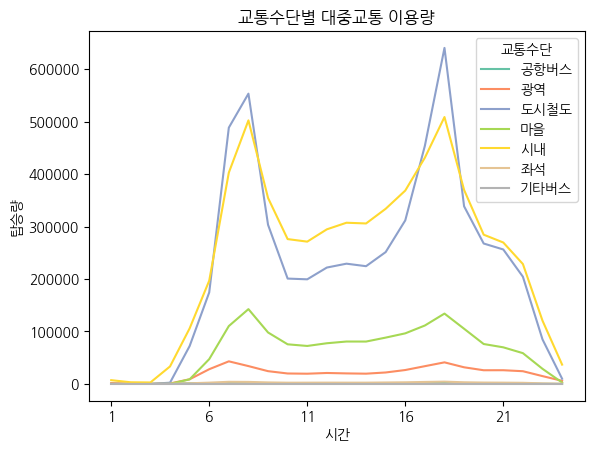

In [57]:
plt.figure(figsize=(10,6))
transp_way.plot(colormap='Set2')
plt.xlabel("시간")
plt.ylabel("탑승량")
plt.title("교통수단별 대중교통 이용량")
plt.show()

## 주로 출퇴근시간에 많이 탑승객들이 몰려있다.
### 도시철도, 시내버스가 가장 많고 마을, 광역버스가 뒤따른다.
### 특히 도시철도는 시내버스에 비해 출퇴근 시간대에 많아지고 다른 시간대에 적어진다.
### 공항버스, 좌석, 기타버스는 다른 교통수단들에 비해 거의 없다.

In [35]:
sql="""select 이용자유형, sum(1시발생량),sum(2시발생량),sum(3시발생량), sum(4시발생량),sum(5시발생량),sum(5시발생량),sum(6시발생량),sum(7시발생량),sum(8시발생량),sum(9시발생량),sum(10시발생량),sum(11시발생량),sum(12시발생량),sum(13시발생량),sum(14시발생량),sum(15시발생량),sum(16시발생량),sum(17시발생량),sum(18시발생량),sum(19시발생량),sum(20시발생량),sum(21시발생량),sum(22시발생량),sum(23시발생량),sum(24시발생량) from method_traffic group by 이용자유형"""
cursor.execute(sql)
user_way = pd.DataFrame(cursor.fetchall())

In [36]:
column_name=['이용자유형']
for i in range(1,25):
    column_name.append(i)

In [37]:
user_way.columns=column_name
user_way = user_way.set_index("이용자유형", drop=True)
user_way=user_way.astype(int)
user_way = user_way.transpose()
user_way /=2250

# 이용자 유형별 대중교통 탑승량

<Figure size 1000x600 with 0 Axes>

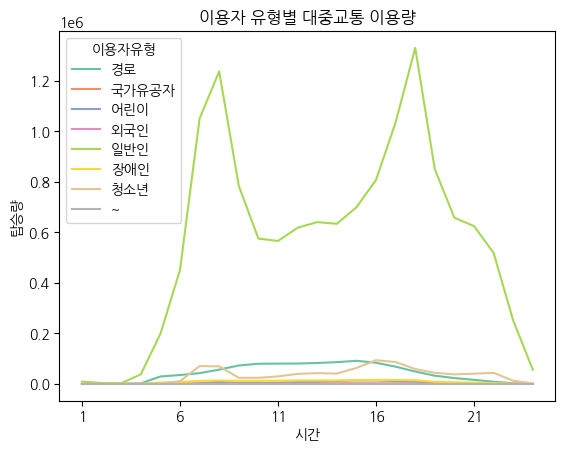

In [55]:
plt.figure(figsize=(10,6))
user_way.plot(colormap='Set2')
plt.xlabel("시간")
plt.ylabel("탑승량")
plt.title("이용자 유형별 대중교통 이용량")
plt.show()

## 일반인이 가장 많고 출퇴근 시간에 이용이 두드러진다.

### 일반인을 제외하고 보면

<Figure size 1000x600 with 0 Axes>

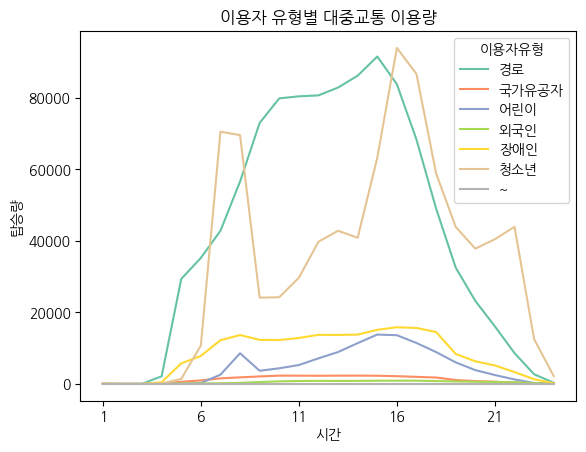

In [54]:
plt.figure(figsize=(10,6))
pd.concat([user_way.iloc[:,0:4],user_way.iloc[:,5:]], axis=1).plot(colormap='Set2')
plt.xlabel("시간")
plt.ylabel("탑승량")
plt.title("이용자 유형별 대중교통 이용량")
plt.show()

## 출퇴근 시간에 청소년들이 많이 타고 나머지는 출퇴근 시간과 크게 관계없다.
### 출퇴근 시간 이외에는 경로가 가장 이용수가 많다
### 밤에 청소년 탑승이 늘어나는 시간대가 있다 (고등학교 야자때문인듯?)

In [40]:
user_way.sum(axis=0)

이용자유형
경로       1.026107e+06
국가유공자    3.014324e+04
어린이      1.140861e+05
외국인      1.143164e+04
일반인      1.364354e+07
장애인      2.045457e+05
청소년      8.382815e+05
~        3.422222e-02
dtype: float64

#### 의외로 외국인보다 국가유공자 탑승량이 많다

## 탑승시간과 도착시간의 간격을 알아보자

In [41]:
sql = """select 시도, sum(1시발생량),sum(2시발생량),sum(3시발생량), sum(4시발생량),sum(5시발생량),sum(5시발생량),sum(6시발생량),sum(7시발생량),sum(8시발생량),sum(9시발생량),sum(10시발생량),sum(11시발생량),sum(12시발생량),sum(13시발생량),sum(14시발생량),sum(15시발생량),sum(16시발생량),sum(17시발생량),sum(18시발생량),sum(19시발생량),sum(20시발생량),sum(21시발생량),sum(22시발생량),sum(23시발생량),sum(24시발생량) from method_traffic group by 시도"""
cursor.execute(sql)
sido_leave=pd.DataFrame(cursor.fetchall())

In [42]:
sql = """select 시도, sum(1시도착량),sum(2시도착량),sum(3시도착량), sum(4시도착량),sum(5시도착량),sum(5시도착량),sum(6시도착량),sum(7시도착량),sum(8시도착량),sum(9시도착량),sum(10시도착량),sum(11시도착량),sum(12시도착량),sum(13시도착량),sum(14시도착량),sum(15시도착량),sum(16시도착량),sum(17시도착량),sum(18시도착량),sum(19시도착량),sum(20시도착량),sum(21시도착량),sum(22시도착량),sum(23시도착량),sum(24시도착량) from method_traffic group by 시도"""
cursor.execute(sql)
sido_arrive=pd.DataFrame(cursor.fetchall())

In [43]:
sql = """select sum(1시발생량),sum(2시발생량),sum(3시발생량), sum(4시발생량),sum(5시발생량),sum(5시발생량),sum(6시발생량),sum(7시발생량),sum(8시발생량),sum(9시발생량),sum(10시발생량),sum(11시발생량),sum(12시발생량),sum(13시발생량),sum(14시발생량),sum(15시발생량),sum(16시발생량),sum(17시발생량),sum(18시발생량),sum(19시발생량),sum(20시발생량),sum(21시발생량),sum(22시발생량),sum(23시발생량),sum(24시발생량) from method_traffic"""
cursor.execute(sql)
leave_time=pd.DataFrame(cursor.fetchall())
sql = """select sum(1시도착량),sum(2시도착량),sum(3시도착량), sum(4시도착량),sum(5시도착량),sum(5시도착량),sum(6시도착량),sum(7시도착량),sum(8시도착량),sum(9시도착량),sum(10시도착량),sum(11시도착량),sum(12시도착량),sum(13시도착량),sum(14시도착량),sum(15시도착량),sum(16시도착량),sum(17시도착량),sum(18시도착량),sum(19시도착량),sum(20시도착량),sum(21시도착량),sum(22시도착량),sum(23시도착량),sum(24시도착량) from method_traffic"""
cursor.execute(sql)
arrive_time=pd.DataFrame(cursor.fetchall())

In [44]:
column_name=[]
for i in range(1,25):
    column_name.append(i)
leave_time.columns=column_name
leave_time=leave_time.astype(int)
leave_time = leave_time.transpose()

arrive_time.columns=column_name
arrive_time=arrive_time.astype(int)
arrive_time = arrive_time.transpose()

## 탑승시간과 도착시간의 관계

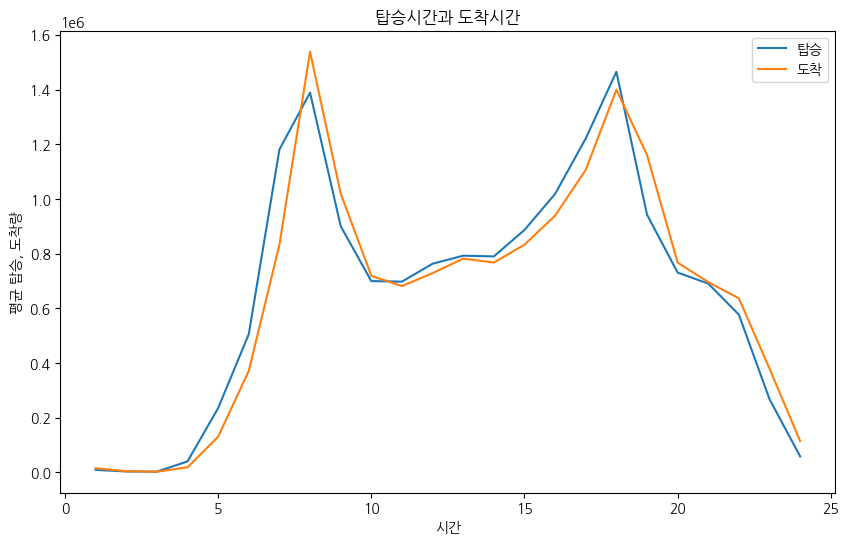

In [53]:
plt.figure(figsize=(10,6))
plt.plot(leave_time/2250, label="탑승")
plt.plot(arrive_time/2250, label="도착")
plt.xlabel("시간")
plt.ylabel("평균 탑승, 도착량")
plt.legend()
plt.title("탑승시간과 도착시간")
plt.show()

## 도착시간은 탑승시간보다 30분정도 늦는다
## 따라서 이동시간이 약 30분정도 되는것 같다

In [46]:
sql = """select sum(1시발생량),sum(2시발생량),sum(3시발생량), sum(4시발생량),sum(5시발생량),sum(5시발생량),sum(6시발생량),sum(7시발생량),sum(8시발생량),sum(9시발생량),sum(10시발생량),sum(11시발생량),sum(12시발생량),sum(13시발생량),sum(14시발생량),sum(15시발생량),sum(16시발생량),sum(17시발생량),sum(18시발생량),sum(19시발생량),sum(20시발생량),sum(21시발생량),sum(22시발생량),sum(23시발생량),sum(24시발생량) from method_traffic where 시도='서울특별시'"""
cursor.execute(sql)
seoul_time=pd.DataFrame(cursor.fetchall())

seoul_time.columns=column_name
seoul_time=seoul_time.astype(int)
seoul_time = seoul_time.transpose()

In [49]:
sql = """select sum(1시발생량),sum(2시발생량),sum(3시발생량), sum(4시발생량),sum(5시발생량),sum(5시발생량),sum(6시발생량),sum(7시발생량),sum(8시발생량),sum(9시발생량),sum(10시발생량),sum(11시발생량),sum(12시발생량),sum(13시발생량),sum(14시발생량),sum(15시발생량),sum(16시발생량),sum(17시발생량),sum(18시발생량),sum(19시발생량),sum(20시발생량),sum(21시발생량),sum(22시발생량),sum(23시발생량),sum(24시발생량) from method_traffic where 시도='경기도'"""
cursor.execute(sql)
gyunggi_time=pd.DataFrame(cursor.fetchall())

gyunggi_time.columns=column_name
gyunggi_time=gyunggi_time.astype(int)
gyunggi_time = gyunggi_time.transpose()

In [50]:
sql = """select sum(1시발생량),sum(2시발생량),sum(3시발생량), sum(4시발생량),sum(5시발생량),sum(5시발생량),sum(6시발생량),sum(7시발생량),sum(8시발생량),sum(9시발생량),sum(10시발생량),sum(11시발생량),sum(12시발생량),sum(13시발생량),sum(14시발생량),sum(15시발생량),sum(16시발생량),sum(17시발생량),sum(18시발생량),sum(19시발생량),sum(20시발생량),sum(21시발생량),sum(22시발생량),sum(23시발생량),sum(24시발생량) from method_traffic where 시도='인천광역시'"""
cursor.execute(sql)
incheon_time=pd.DataFrame(cursor.fetchall())

incheon_time.columns=column_name
incheon_time=incheon_time.astype(int)
incheon_time = incheon_time.transpose()

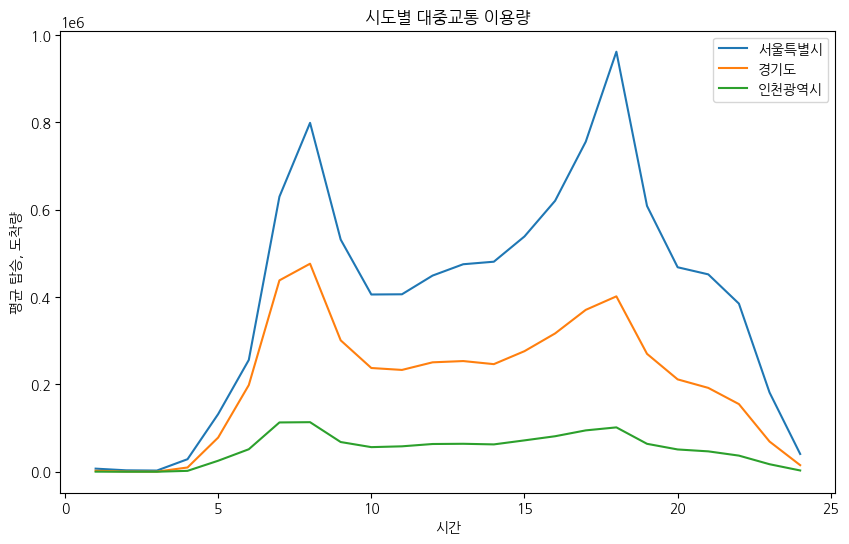

In [52]:
plt.figure(figsize=(10,6))
plt.plot(seoul_time/2250, label="서울특별시")
plt.plot(gyunggi_time/2250, label="경기도")
plt.plot(incheon_time/2250, label="인천광역시")
plt.xlabel("시간")
plt.ylabel("평균 탑승, 도착량")
plt.legend()
plt.title("시도별 대중교통 이용량")
plt.show()

In [85]:
sql = """select 교통수단, sum(합계발생량) as 이용량 from method_traffic where 시도='경기도' group by 교통수단"""
cursor.execute(sql)
gyunggi_traffic_use=pd.DataFrame(cursor.fetchall())

In [87]:
sql = """select 교통수단, sum(합계발생량) as 이용량 from method_traffic where 시도='서울특별시' group by 교통수단"""
cursor.execute(sql)
seoul_traffic_use=pd.DataFrame(cursor.fetchall())

## 시도별 교통수단 선호 순위

<Figure size 800x600 with 0 Axes>

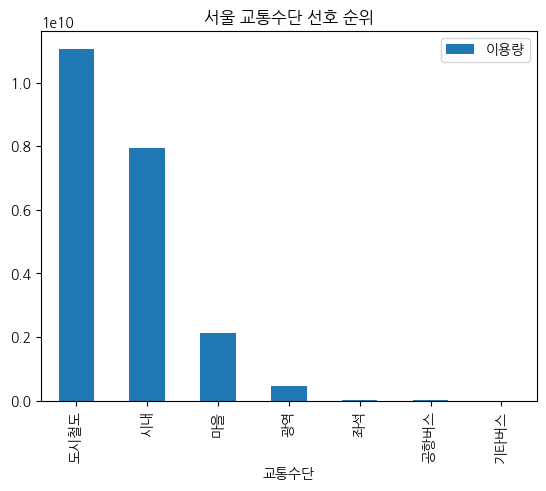

In [93]:
seoul_traffic_use=seoul_traffic_use.set_index("교통수단").astype(int).sort_values(by="이용량", ascending=False)
plt.figure(figsize=(8,6))
seoul_traffic_use.plot(kind="bar")
plt.title("서울 교통수단 선호 순위")
plt.show()

<Figure size 800x600 with 0 Axes>

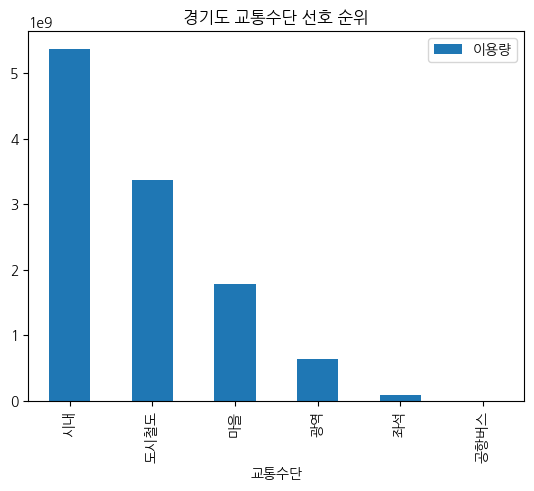

In [91]:
gyunggi_traffic_use=gyunggi_traffic_use.set_index("교통수단").astype(int).sort_values(by="이용량", ascending=False)
plt.figure(figsize=(8,6))
gyunggi_traffic_use.plot(kind="bar")
plt.title("경기도 교통수단 선호 순위")
plt.show()

In [89]:
sql = """select 교통수단, sum(합계발생량) as 이용량 from method_traffic where 시도='인천광역시' group by 교통수단"""
cursor.execute(sql)
incheon_traffic_use=pd.DataFrame(cursor.fetchall())

<Figure size 800x600 with 0 Axes>

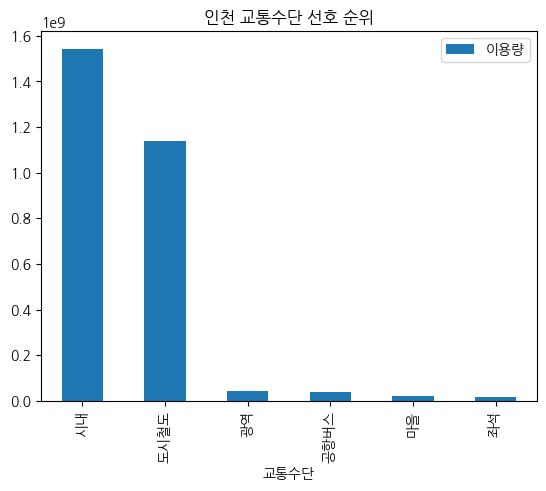

In [92]:
incheon_traffic_use=incheon_traffic_use.set_index("교통수단").astype(int).sort_values(by="이용량", ascending=False)
plt.figure(figsize=(8,6))
incheon_traffic_use.plot(kind="bar")
plt.title("인천 교통수단 선호 순위")
plt.show()

## 서울만 도시철도를 가장 선호하고 나머지는 시내버스를 가장 선호한다